In [10]:
import matplotlib.pyplot as plt
import numpy as np
from mne.decoding import CSP
from sklearn.model_selection import train_test_split

from processing.preprocessing import BCIDataProcessor

recording_path = '../recordings/recording_imagery1_gel.raw.fif'
window_size = 2
window_overlap = 1
processor = BCIDataProcessor(recording_path, l_freq=7, h_freq=30, window_size=window_size,
                             window_overlap=window_overlap)
data = processor.process()
# Only select left_hand and right_hand
data = {label: data[label] for label in data.keys() if label in ['left_hand', 'right_hand']}
data

{'left_hand': array([[[-1.11130723e-17,  1.21498049e-04,  2.05445393e-04, ...,
          -1.24708846e-06, -3.91301888e-06, -6.37336978e-06],
         [-1.57209315e-17,  4.91073347e-05,  8.34634790e-05, ...,
           9.24094209e-07, -2.33323058e-06, -6.14365884e-06],
         [-8.34835673e-18,  4.66229882e-05,  7.87039089e-05, ...,
          -1.71352713e-06, -4.08530822e-06, -6.66718780e-06],
         ...,
         [-1.20346441e-17,  2.19030216e-05,  3.78341653e-05, ...,
           3.71476184e-06,  5.30173495e-06,  4.74954687e-06],
         [-1.55583012e-17,  2.82491394e-05,  4.79878220e-05, ...,
           1.63359098e-06,  2.75866407e-06,  1.53126615e-06],
         [-5.36680075e-18,  3.24646917e-07, -6.82607416e-08, ...,
           7.81905068e-06,  8.54439178e-06,  5.81133665e-06]],
 
        [[ 5.07744079e-06,  1.89221602e-05,  2.36216363e-05, ...,
          -1.03253220e-04, -4.70965333e-05,  9.95352824e-06],
         [ 1.11141194e-05,  1.63585139e-05,  1.57505358e-05, ...,
        

In [11]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [12]:
X.shape, y.shape, X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape

((112, 8, 500), (112,), (89, 8, 500), (89,), (23, 8, 500), (23,))

Classification accuracy: 0.7666666666666667 / Chance level: 0.5056179775280899


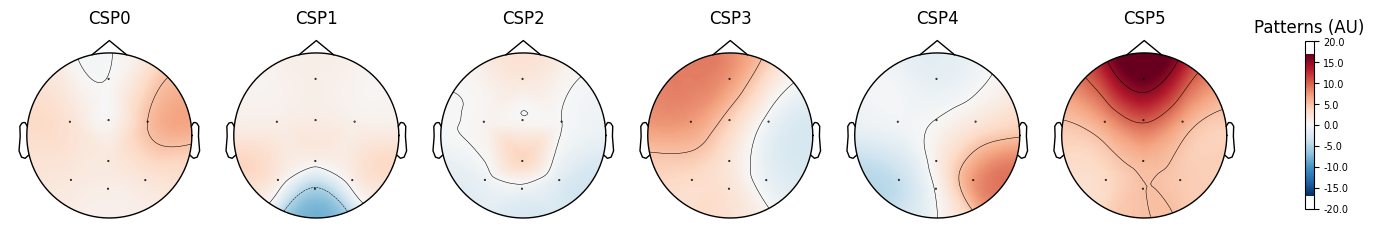

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(X_trainval, y_trainval)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=6, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, X_trainval, y_trainval, cv=cv_split, n_jobs=1)

# Printing the results
class_balance = np.mean(y_trainval == "left_hand")
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(X, y)
csp.plot_patterns(processor.raw.info, ch_type="eeg", units="Patterns (AU)", size=1.5)
plt.show()